In [42]:
%config IPCompleter.use_jedi = False
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

from dfply import *

%run -i 'model_helpers.py'

In [2]:
df = load_query_avg_data_exp2() # see data_helpers.py
df = df[df["condition"]!=2] # filter out "warm/snowy" as per paper
df.head()


,ID,condition,querytype,querydetail,estimate
0,0,0,A,windy,0.733333
1,0,0,AandB,windy and cloudy,0.773333
2,0,0,AandnotB,windy and not cloudy,0.676667
3,0,0,AgB,windy given cloudy,0.816667
4,0,0,AgnotB,windy given not cloudy,0.600000


In [3]:
X_data, y_data = make_model_data(df) # see data_helpers.py

# Bayesian sampler model

One thing to figure out is whether this should follow the paper and constraint $\beta \in [0,1]$ or allow it to vary more freely. From what I can tell there's no reason to think it couldn't be greater than 1, I believe they just added this constraint to make it easier to compare the parameters across models.

In [4]:
def prob_judge_BS(theta, X_num, X_denom, N, beta):

    numerator = jnp.sum(theta*X_num, axis=-1)
    denom = jnp.sum(theta*X_denom, axis=-1)
    pi = jnp.divide(numerator, denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs


def bayesian_sampler_complex(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
#         betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
        betas = numpyro.sample("beta", dist.Normal(0,1))
#         N_deltas = numpyro.sample("N_delta", dist.HalfNormal(50))
#         N_primes = numpyro.sample("N_prime", dist.HalfNormal(50))
        N_deltas = numpyro.sample("N_delta", dist.Normal(0,3)) # 3/25/21, 11:10 PM changed this
        N_primes = numpyro.sample("N_prime", dist.Normal(0,3))
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    beta = jnp.exp(betas[subj]) # use jnp.exp() if unbounded
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
#     N = 1 + N_primes[subj] + N_deltas[subj] * not_conjdisj 
    N_lin = N_primes[subj] + N_deltas[subj] * not_conjdisj #  < -------------- gah, fix this 3/26/21, 9:41 AM
    N = 1 + jnp.exp(N_lin) # they required N be at least 1
    
    p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [5]:
mcmc_bs = MCMC(NUTS(bayesian_sampler_complex, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
# mcmc_bs.print_summary()

Participant mean response corr =  0.685
Query-level corr 0.861


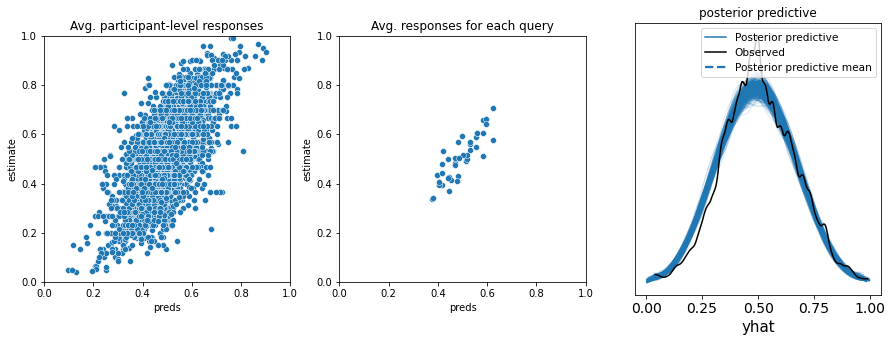

In [43]:
az_data_bs = make_arviz_data(mcmc_bs, bayesian_sampler_complex, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs)

# Relative Frequency model


In [38]:
def relative_freq(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])

    # population level parameters/priors
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # need a theta per person-query
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
        
    numerator = jnp.sum(theta*X_num, axis=-1)
    denom = jnp.sum(theta*X_denom, axis=-1)
    pi = jnp.divide(numerator, denom)

    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(pi, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(pi*k, (1-pi)*k), obs=y)
    
    return yhat

In [39]:
mcmc_rf = MCMC(NUTS(relative_freq, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_rf.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [40]:
# mcmc_rf.print_summary()

Participant mean response corr =  0.517
Query-level corr 0.64


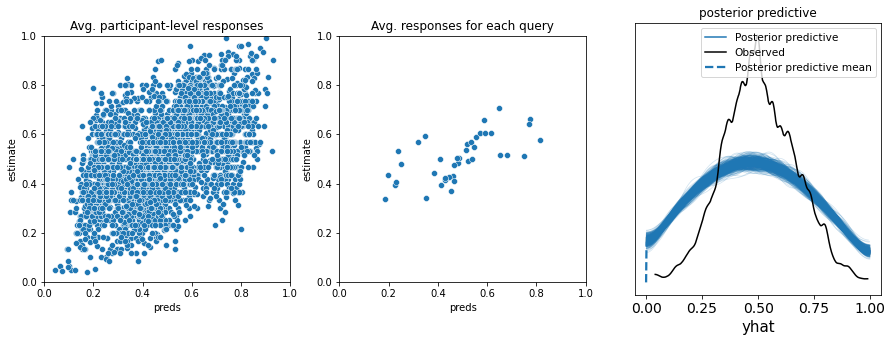

In [44]:
az_data_rf = make_arviz_data(mcmc_rf, relative_freq, X_data) # see model_helpers.py
plot_model_preds(df, az_data_rf)

# Probability theory plus noise (PT+N) model

In [45]:
def prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d):
    
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)
    
    p_numerator = jnp.sum(theta*X_num, axis=-1) #  = P(A & B)
    pA = jnp.sum(theta*X_A, axis=-1)
    num_or_denom = jnp.logical_or(X_A, X_denom).astype("float32")
    p_num_or_denom = jnp.sum(theta * num_or_denom , axis=-1) # = P(A or B)


    p_denom = jnp.sum(theta*X_denom, axis=-1)
    numerator = ((p_numerator)*(1-2*d)**2 + d*(1-2*d)*(pA + p_denom) + d**2)*conditional + ((1 - 2*d)*p_numerator + d)*not_conditional
    denom = ((1 - 2*d)*p_denom  + d)*conditional + p_denom*not_conditional
    
    return jnp.divide(numerator, denom) # move division to after noise is added

def PTN_complex(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    X_A = jnp.stack([pA_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)
    
    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

    # Subject-level parameters/priors
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base", dist.Normal(0, 1))
        d_deltas = numpyro.sample("d_delta", dist.Normal(0, 1)) # sum of these is approx uniform and each can span approx full [.05, .95]
        
    # Subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    d_lin = d_bases[subj] + jnp.exp(d_deltas[subj]) * conjdisj # constrain d < d'
    d = sigmoid(d_lin)/2. # require this be below .50
    
    theta_ind = (subj*n_conds) + cond
    theta = thetas[theta_ind,:]
    
    p_ptn = prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d) #

    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_ptn, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_ptn*k, (1-p_ptn)*k), obs=y)
    
    return yhat

In [46]:
mcmc_ptn = MCMC(NUTS(PTN_complex, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [47]:
# mcmc_ptn.print_summary()

Participant mean response corr =  0.668
Query-level corr 0.841


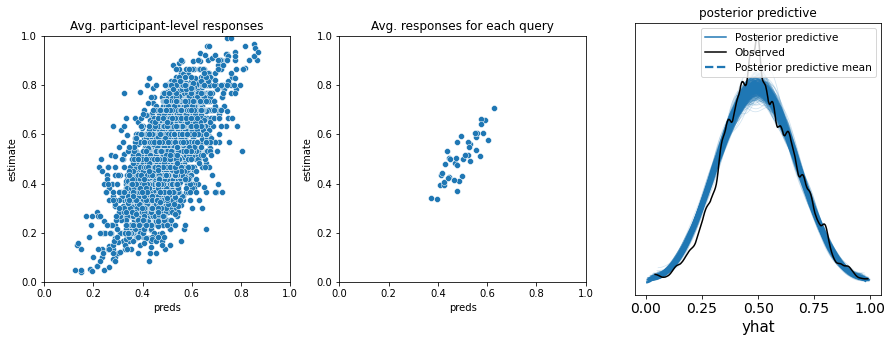

In [48]:
az_data_ptn = make_arviz_data(mcmc_ptn, PTN_complex, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn)

In [49]:
az.compare({"P+TN":az_data_ptn, "Bayesian Sampler": az_data_bs, "Relative Freq.":az_data_rf}, scale="deviance", ic="loo")

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is becau

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Bayesian Sampler,0,-3899.582371,404.818830,0.000000,0.995689,82.259384,0.000000,True,deviance
P+TN,1,-3769.284205,397.915260,130.298165,0.000814,82.123881,22.522114,True,deviance
Relative Freq.,2,-1285.147387,425.360835,2614.434984,0.003497,92.071025,84.915318,True,deviance


Here there are some "very bad" samples, so need to run `reloo()` to fix those, following this [arviz tutorial](https://arviz-devs.github.io/arviz/user_guide/numpyro_refitting_xr_lik.html) (per this [stackoverflow post](https://stats.stackexchange.com/questions/304958/warnings-during-waic-computation-how-to-proceed)).

But if these can be trusted, Bayesian Sampler is the winning model. Interesting to me the RF has a higher p_loo than both, given that it has fewer parameters. I wonder if that's because it just can't get any good estimates so has lots of variance?

# Summary and comparison of models

All three models have now been implemented as probabilistic programs, and we have obtained samples for each. [This paper](https://arxiv.org/abs/1507.04544) describes how to compare them using information criteria.

* Both the PT+N and Bayesian sampler models are far better than the naive relative frequency model.
* If you allow values of $\beta$ greater than 1 in Bayesian Sampler model, then the PT+N and Bayesian sampler models are essentially indistinguishable. 
* But if you constrain $\beta \in [0,1]$, then according to $loo_{ic}$ the PT+N model is the best (now that I have fixed my code) and the Bayesian Sampler is in second. 

# Hierarchical Bayesian Sampler

Here's a quick implementation of a hierarchical version of the Bayesian Sampler, which requires reparameterization of some components. It samples reasonably quickly and does better in terms of $loo_{ic}$ as well as $R^2$ on the trial averages.

In [50]:
def bayesian_sampler_complex_mlm(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(0, 1)) # roughly uniform after summing with random effects + sigmoid()
    beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(1))
    
    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,2)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,2)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(2))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(2))

    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, beta_sd))
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, N_delta_sd))
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, N_prime_sd))
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
#     beta = sigmoid(beta_pop + betas[subj]) # constrains beta to [0,1]
    beta = jnp.exp(beta_pop + betas[subj])
    
    # exp() needed to constrain N and N_delta positive
    N = 1 + jnp.exp(N_prime_pop + N_primes[subj]) + jnp.exp(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1
    
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
        
    p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [65]:
mcmc_bs_mlm = MCMC(NUTS(bayesian_sampler_complex_mlm, target_accept_prob=.90), # need the higher prob and more samples to get good rhats
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=2)

mcmc_bs_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [131]:
# mcmc_bs_mlm.print_summary()

Participant mean response corr =  0.688
Query-level corr 0.876


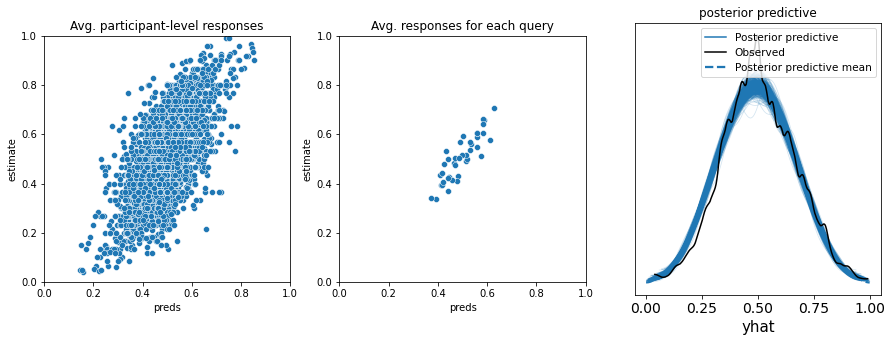

In [68]:
az_data_bs_mlm = make_arviz_data(mcmc_bs_mlm, bayesian_sampler_complex_mlm, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_mlm)

# Hierarchical PT+N


In [54]:
def PTN_complex_mlm(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    X_A = jnp.stack([pA_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)
    
    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    d_base_pop = numpyro.sample("d_base_pop", dist.Normal(-1.1, 1.6))
    d_delta_pop = numpyro.sample("d_delta_pop", dist.Normal(0, .5)) # together approx uniform
    d_base_sd = numpyro.sample("d_base_sd", dist.HalfCauchy(1))
    d_delta_sd = numpyro.sample("d_delta_sd", dist.HalfCauchy(1))

    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base_r", dist.Normal(0, d_base_sd))
        d_deltas = numpyro.sample("d_delta_r", dist.Normal(0, d_delta_sd))
        
    # Subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    d_lin = d_base_pop + d_bases[subj] + jnp.exp(d_delta_pop + d_deltas[subj])*conjdisj  # exp() constrains d_delta to be positive
    d = sigmoid(d_lin)/2 # require this be in [0,.50]
    
    theta_ind = (subj*n_conds) + cond
    theta = thetas[theta_ind,:]
    
    p_ptn = prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d) #

    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_ptn, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_ptn*k, (1-p_ptn)*k), obs=y)
    
    return yhat

In [55]:
mcmc_ptn_mlm = MCMC(NUTS(PTN_complex_mlm, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_ptn_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [61]:
# mcmc_ptn_mlm.print_summary()

Participant mean response corr =  0.659
Query-level corr 0.835


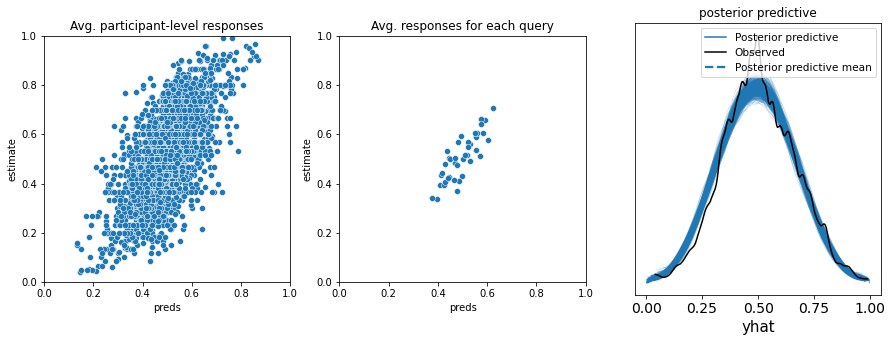

In [57]:
az_data_ptn_mlm = make_arviz_data(mcmc_ptn_mlm, PTN_complex_mlm, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_mlm)

In [69]:
az.compare({"PTN_mlm":az_data_ptn_mlm, "BS_mlm": az_data_bs_mlm}, scale="deviance", ic="loo")

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is becau

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
BS_mlm,0,-3949.494874,373.593576,0.000000,1.0,80.664432,0.000000,True,deviance
PTN_mlm,1,-3793.685555,356.209682,155.809319,0.0,81.096460,21.564508,True,deviance


# Summary of hierarchical models

If you allow values of $\beta$ greater than 1 in Bayesian Sampler model, then a hierarchical implementation of that model pulls ahead of a hierarchical implementation of PT+N.

If these results are to be trusted it's pretty decisive in favor of the Bayesian Sampler using the data from Experiment 2 as presented in the original paper.

### A few concerns

* what to do about $\beta$?
* how can I align the priors to fit well?
* Am I putting a weird prior on N in the hierarchical bayesian sampler model?

<AxesSubplot:title={'center':'N_prime_pop'}>

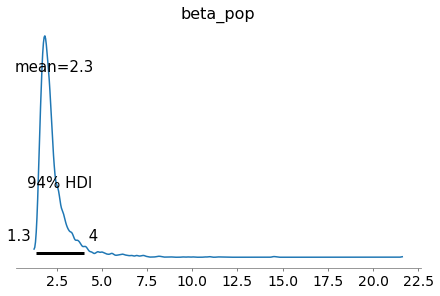

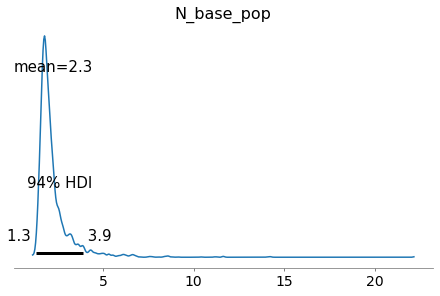

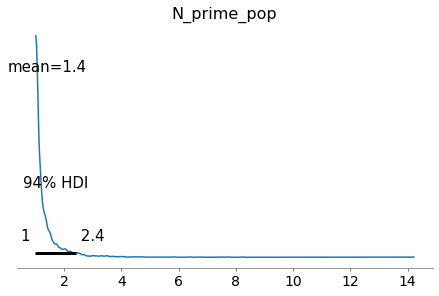

In [150]:
az.plot_posterior(data=az_data_bs_mlm, var_names=["beta_pop"], transform=np.exp)
# az.plot_posterior(data=az_data_bs_mlm, var_names=["beta_sd", "N_prime_sd", "N_delta_sd"], transform=np.exp)

az_data_bs_mlm.posterior["N_base_pop"] = 1 + np.exp(az_data_bs_mlm.posterior.N_prime_pop) + np.exp(az_data_bs_mlm.posterior.N_delta_pop)
az.plot_posterior(az_data_bs_mlm, var_names=["N_base_pop"])
az.plot_posterior(az_data_bs_mlm, var_names=["N_prime_pop"], transform = lambda x: 1 + np.exp(x))

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

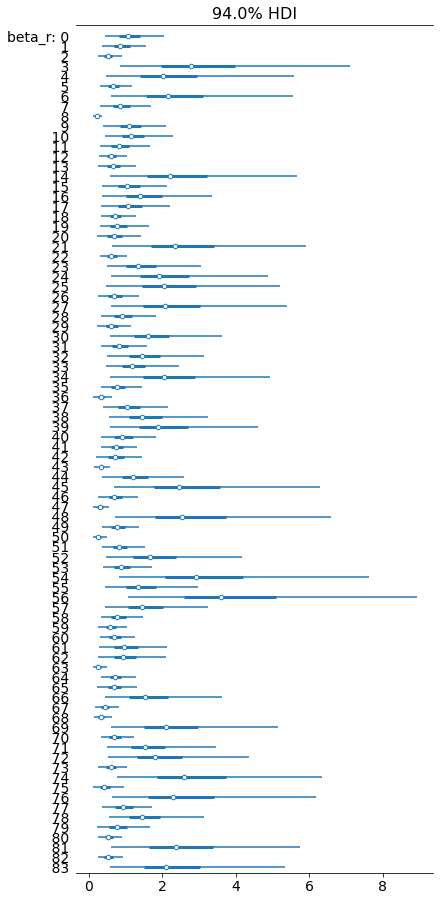

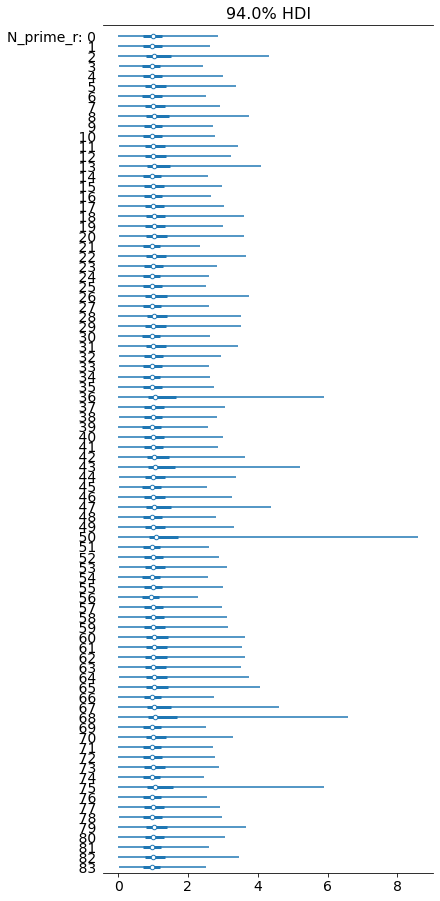

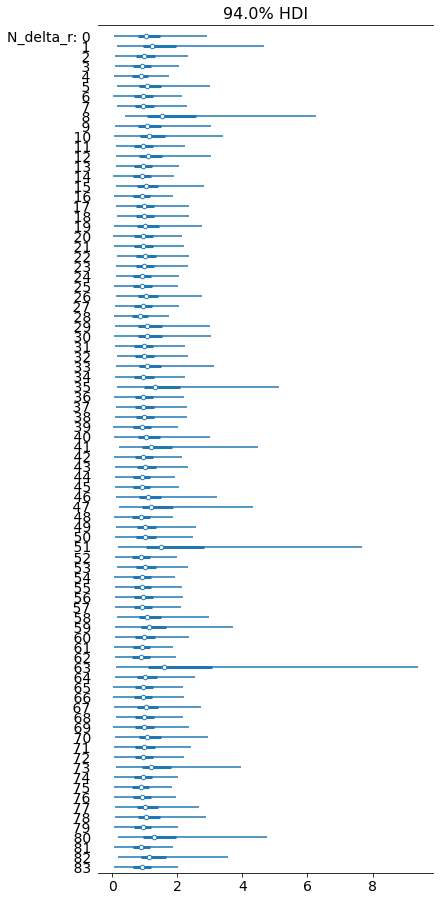

In [152]:
az.plot_forest(data=az_data_bs_mlm, var_names=["beta_r"], transform=np.exp, combined=True)
az.plot_forest(data=az_data_bs_mlm, var_names=["N_prime_r"], transform=np.exp, combined=True)
az.plot_forest(data=az_data_bs_mlm, var_names=["N_delta_r"], transform=np.exp, combined=True)

## PT+N

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

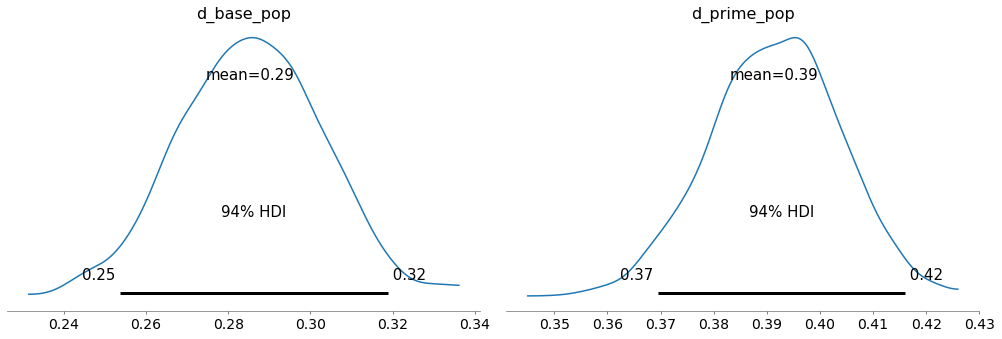

In [165]:
az_data_ptn_mlm.posterior["d_prime_pop"] = az_data_ptn_mlm.posterior.d_base_pop + np.exp(az_data_ptn_mlm.posterior.d_delta_pop)
az.plot_posterior(az_data_ptn_mlm, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)


In [167]:
## something wrong with this, unsure what.
# az.plot_forest(data=az_data_ptn_mlm, var_names=["d_base_r"], filter_vars="like", transform=lambda x: np.exp(-np.logaddexp(0, -x))/2, combined=True)

# az_data_ptn_mlm.posterior = az_data_ptn_mlm.posterior.assign(d_base_r = az_data_ptn_mlm.posterior.d_base_r + np.exp(az_data_ptn_mlm.posterior.d_delta_r))
# az.plot_forest(data=az_data_ptn_mlm, var_names = ["d_base_r"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2, combined=True)
